# **Expectation Maximization for Gaussian Mixture Models**

Given data X of two-dimensinal points ($x_i$ is a 2D data point) that are generated from a mixture of a finite number of Gaussian distributions with unknown parameters, we can apply the EM algorithm for estimating the parameters of these GMMs.  
In the GMM framework, each Gaussian component is characterized by its mean $\mu$, covariance matrix $\Sigma$, and mixture coefficient (weight) $\beta$.  
  
For each iteration $t$, the E-Step and the M-Step are taken:  
In the expectation step ($\boldsymbol{E-Step}$), we compute the posterior probabilities of each data point belonging to each of the Gaussian components:    
$$P(x_i|N_j^t) = \frac{p(x_i|\mu_j, \Sigma_j) \beta_j^t}{ \Sigma_{k=1}^c p(x_i|\mu_k, \Sigma_k)\beta_k^t}$$   
  

In the maximization step ($\boldsymbol{M-Step}$), the probabilities from the E-Step are used to update the estimates of the mixture weights and the means and covariances of each Gaussian component:
$$\beta_j^{t+1} = \frac{\Sigma_{i=1}^n P(x_i|N_j^t)}{n}$$   
  
$$\mu_j^{t+1} = \frac{\Sigma_{i=1}^n P(x_i|N_j^t) x_i}{\Sigma_{i=1}^n P(x_i|N_j^t)}$$  
  
$$\Sigma_j^{t+1} = \frac{\Sigma_{i=1}^n P(x_i|N_j^t) (x_i-μ_j^t) (x_i-μ_j^t)^\top}{\Sigma_{i=1}^n P(x_i|N_j^t)}$$  



In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

In [ ]:
class Server:
  """
  This class represents the server - a trusted third party.

  Attributes:
  -----------
  num_of_clients:
      The total number of clients (data points).

  vectors:
      The vectors sent by clients.
  """

  def __init__(self, num_of_clients):
    self.num_of_clients = num_of_clients
    self.vectors = []

  def add_vec(self, vector):
    """Adds a vector to the server's list of vectors."""
    self.vectors.append(vector)

  def calc_sum(self):
    """Calculates the sum of the vectors stored on the server."""
    if len(self.vectors) != self.num_of_clients:
      raise ValueError("The number of vectors stored on the server does not match the number of clients.")
    return [sum(x) for x in zip(*self.vectors)]

  def clear_server(self):
    """Clears the server's list of vectors."""
    self.vectors = []

In [ ]:
class GMM:
  """
  This class represents a Gaussian Mixture Model (GMM). We wish to fit a GMM to the full dataset of all parties.

  Attributes:
  -----------
  parties:
      The parties (clients) that the data is distributed among them.

  num_of_parties:
      Number of parties (which is the number of data points).

  server: Server
      The server (untrusted third party) to perform computations on the encrypted data.
    
  num_of_gaussians: 
      Number of gaussian components.

  colors_of_gaussians: 
      Colors of the gaussian clusters for poltting. size: (num_of_gaussians, 3).

  means:
      The means of the Gaussian components. size: (num_of_gaussians, 2).
      
  covariances:
      The covariances of the Gaussian components. size: (num_of_gaussians, 2, 2).
      
  coefficients:
      The coefficients of the Gaussian components. size: num_of_gaussians. 
  """

  def __init__(self, parties, num_of_parties, num_of_gaussians):
    self.parties = parties
    self.num_of_parties = num_of_parties
    self.server = Server(num_of_parties)
    self.num_of_gaussians = num_of_gaussians
    self.colors_of_gaussians = random.rand(num_of_gaussians, 3)
    # parameters estimates
    self.means = random.rand(num_of_gaussians, 2)*20 - 10     # initial means: random from uniform[-10, 10] 
    covariances = np.zeros((num_of_gaussians, 2, 2))
    for j in range(num_of_gaussians):
        covariances[j] = np.eye(2)
    self.covariances = covariances
    self.coefficients = np.ones(num_of_gaussians)/num_of_gaussians

  def e_step(self):
    """E-step of EM algorithm."""
    for party in self.parties:
      party.e_step(self)

  def m_step(self):
    """M-step of EM algorithm."""

    for j in range(self.num_of_gaussians):
      for party in self.parties:
        v_ij = party.inter_m_step(j, self)
        self.server.add_vec(v_ij)

      sum_j = self.server.calc_sum()
      self.server.clear_server()

      a_j = sum_j[0]; b_j_0 = sum_j[1]; b_j_1 = sum_j[2]; c_j_00 = sum_j[3]; c_j_01 = sum_j[4]; c_j_10 = sum_j[5]; c_j_11 = sum_j[6];  
      self.coefficients[j] = a_j / self.num_of_parties
      self.means[j][0] = b_j_0 / a_j
      self.means[j][1] = b_j_1 / a_j
      self.covariances[j][0][0] = c_j_00 / a_j
      self.covariances[j][0][1] = c_j_01 / a_j
      self.covariances[j][1][0] = c_j_10 / a_j
      self.covariances[j][1][1] = c_j_11 / a_j    

  def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """Utility function to plot one Gaussian from mean and covariance."""
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

  def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
    """Function to draw the Gaussians."""
    for j in range(self.num_of_gaussians):
        self.plot_gaussian(self.means[j], self.covariances[j], ax, n_std=n_std, edgecolor=self.colors_of_gaussians[j], **kwargs)

In [19]:
class Client:
  """
  This class represents a single party (a client) that holds a data point belonging to a Gaussian Mixture Model (GMM). 
  The data point is represented as a two-dimensional point.

  Attributes:
  -----------
  data: 
      The two-dimensional data point.

  num_of_gaussians:
      Number of gaussian components.
  
  a:
      The intermediate updates for the coefficients of the GMM. size: num_of_gaussians.

  b: 
      The intermediate updates for the means of the GMM. size: (num_of_gaussians, 2).

  c: 
      The intermediate updates for the covariances of the GMM. size: (num_of_gaussians, 2, 2).
  """

  def __init__(self, data, num_of_gaussians):
    self.data = data
    self.num_of_gaussians = num_of_gaussians
    # for intermediate updates
    self.a = np.zeros(num_of_gaussians)      
    self.b = np.zeros((num_of_gaussians, 2))
    self.c = np.zeros((num_of_gaussians, 2, 2))

  def e_step(self, gmm):
    """Performs the E-Step of the EM algorithm. Computes the conditional probabilities that the client's data belongs to each Gaussian model."""
    self.a[:] = [gmm.coefficients[j] * multivariate_normal.pdf(self.data, mean=gmm.means[j], cov=gmm.covariances[j]) for j in range(self.num_of_gaussians)]
    self.a[:] /= self.a[:].sum()

  def inter_m_step(self, j, gmm):
    """Performs the intermediate M-Step calcultaions of the EM algorithm. Computes the local updates for the coefficients, means, and covariances of the GMM."""
    a_j = self.a[j]
    b_j_0 = self.a[j] * self.data[0]
    b_j_1 = self.a[j] * self.data[1]
    c_j_00 = self.a[j] * (self.data[0] - gmm.means[j][0])**2
    c_j_01 = self.a[j] * (self.data[0] - gmm.means[j][0]) * (self.data[1] - gmm.means[j][1])
    c_j_10 = self.a[j] * (self.data[1] - gmm.means[j][1]) * (self.data[0] - gmm.means[j][0])
    c_j_11 = self.a[j] * (self.data[1] - gmm.means[j][1])**2

    v_j = [a_j, b_j_0, b_j_1, c_j_00, c_j_01, c_j_10, c_j_11]
    return v_j

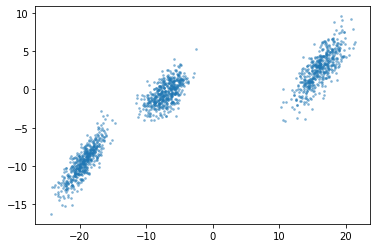

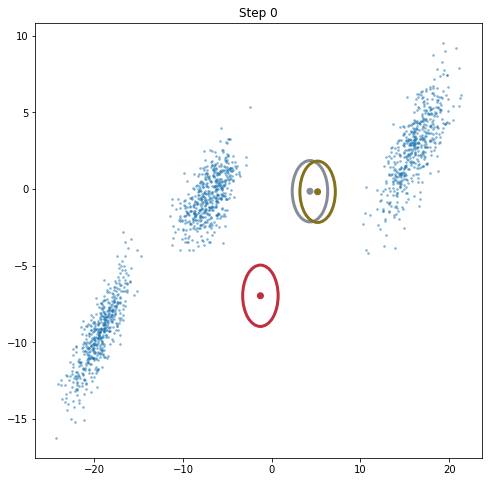

<Figure size 432x288 with 0 Axes>

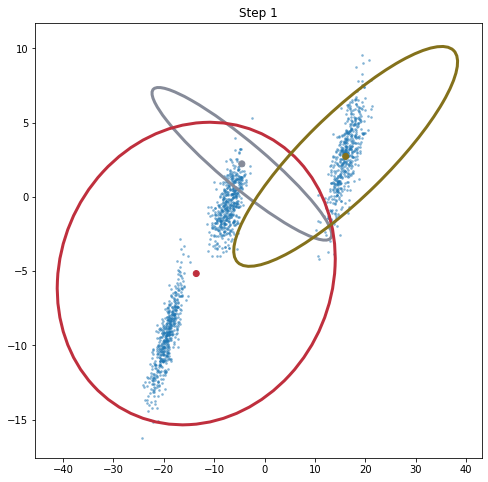

<Figure size 432x288 with 0 Axes>

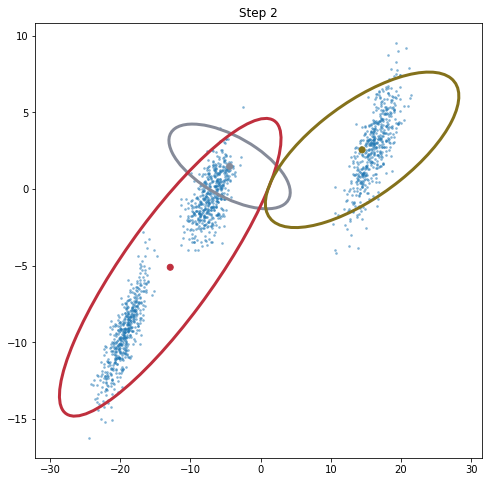

<Figure size 432x288 with 0 Axes>

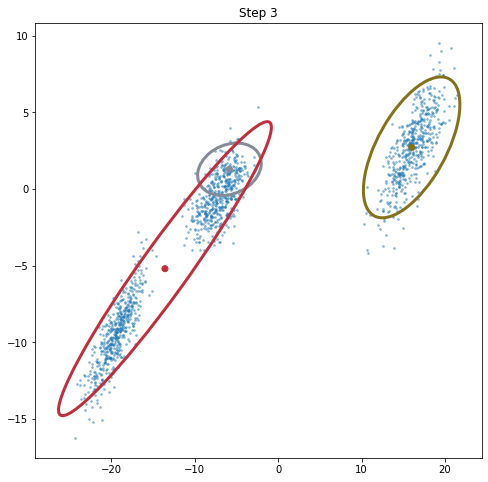

<Figure size 432x288 with 0 Axes>

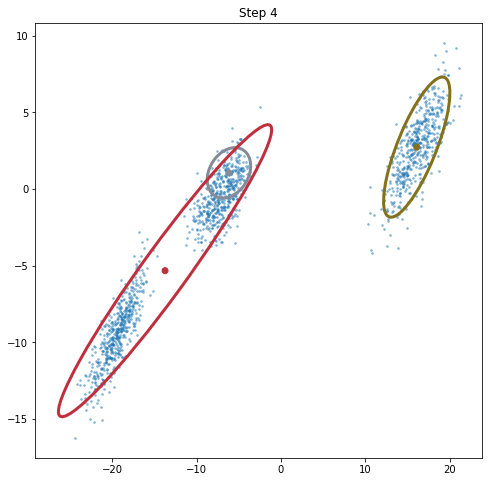

<Figure size 432x288 with 0 Axes>

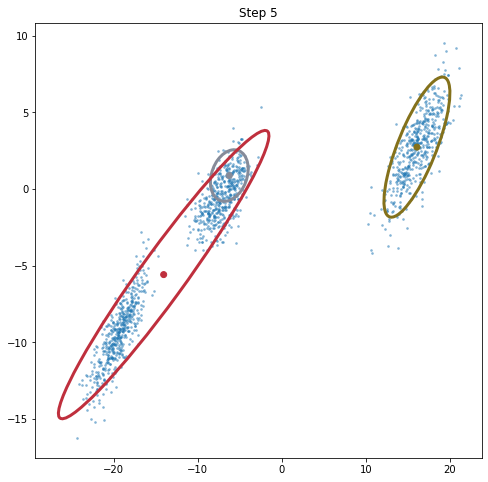

<Figure size 432x288 with 0 Axes>

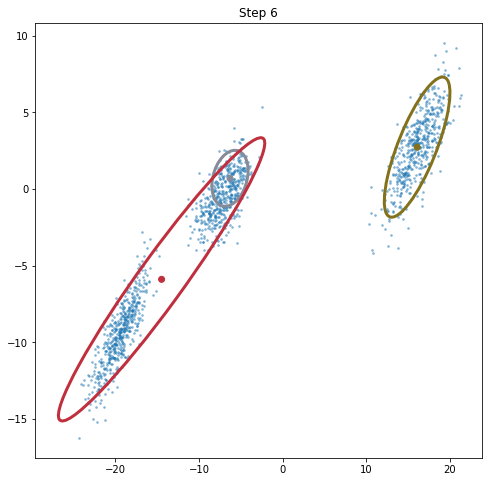

<Figure size 432x288 with 0 Axes>

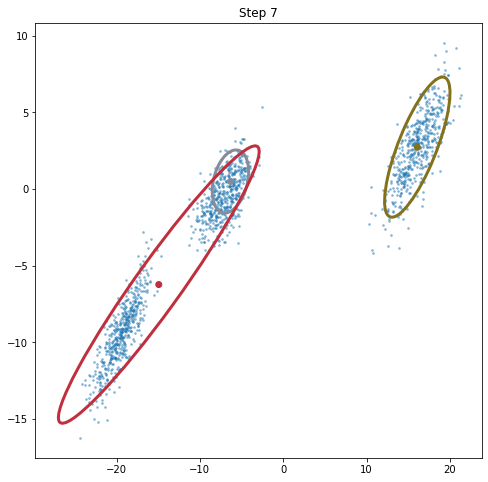

<Figure size 432x288 with 0 Axes>

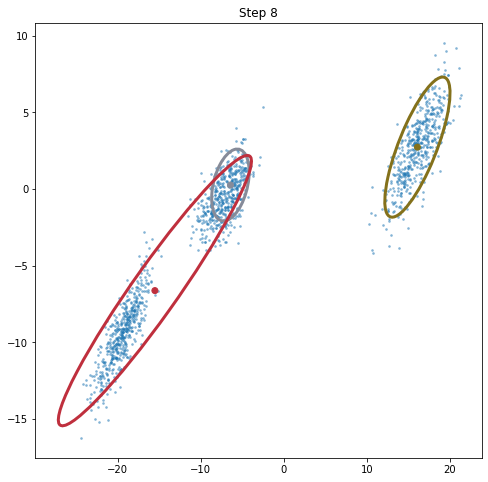

<Figure size 432x288 with 0 Axes>

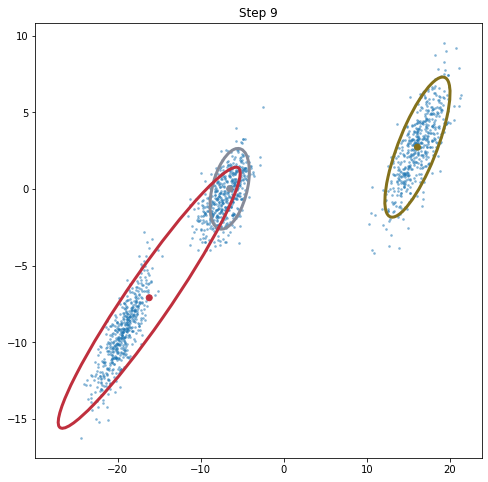

<Figure size 432x288 with 0 Axes>

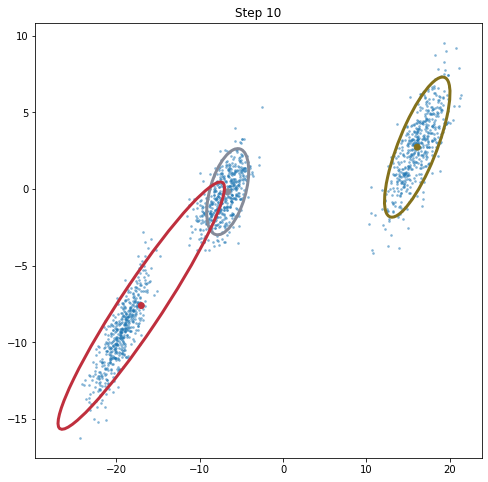

<Figure size 432x288 with 0 Axes>

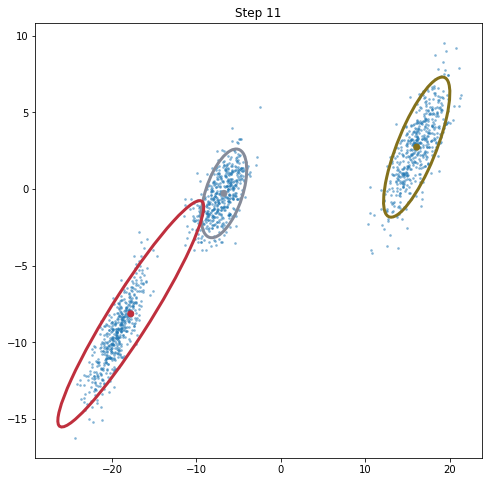

<Figure size 432x288 with 0 Axes>

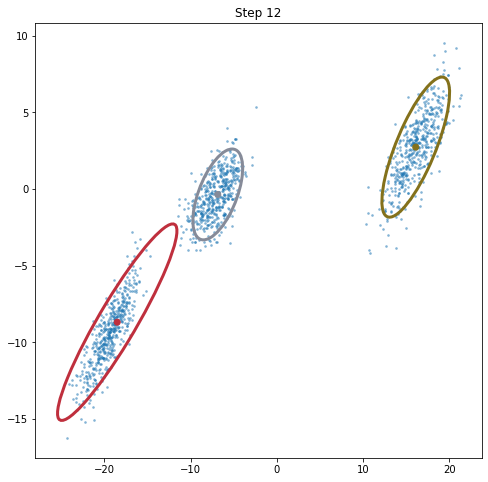

<Figure size 432x288 with 0 Axes>

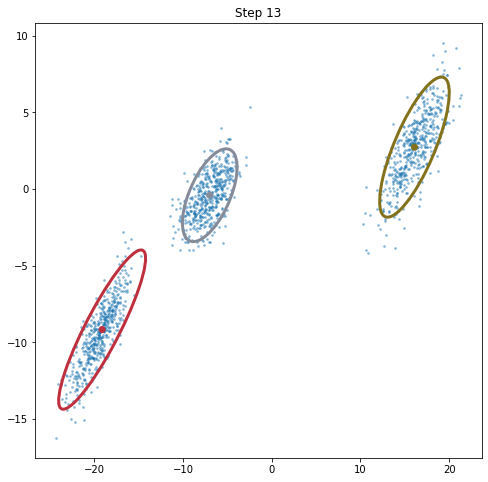

<Figure size 432x288 with 0 Axes>

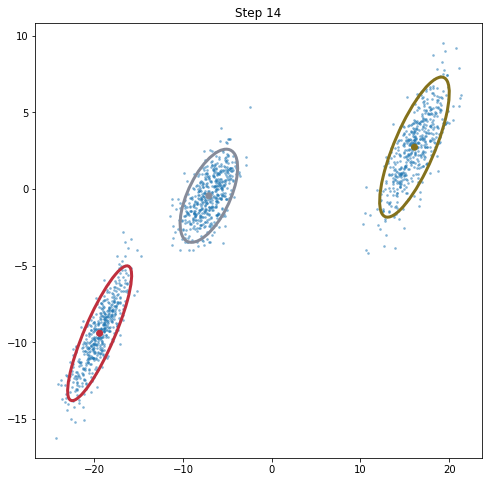

<Figure size 432x288 with 0 Axes>

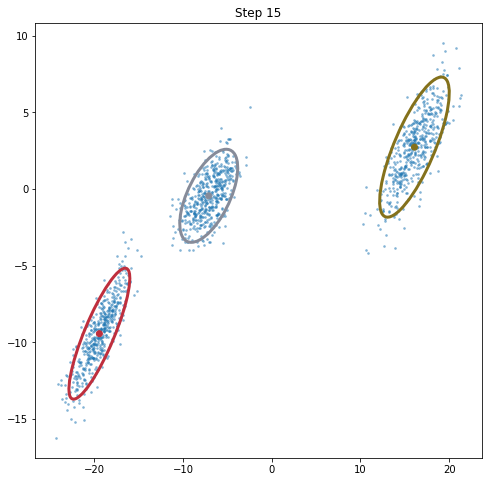

<Figure size 432x288 with 0 Axes>

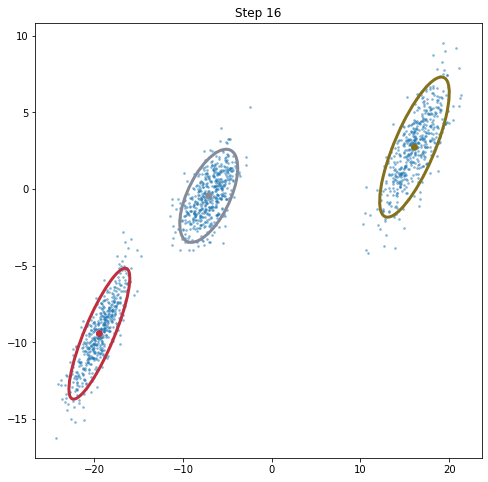

<Figure size 432x288 with 0 Axes>

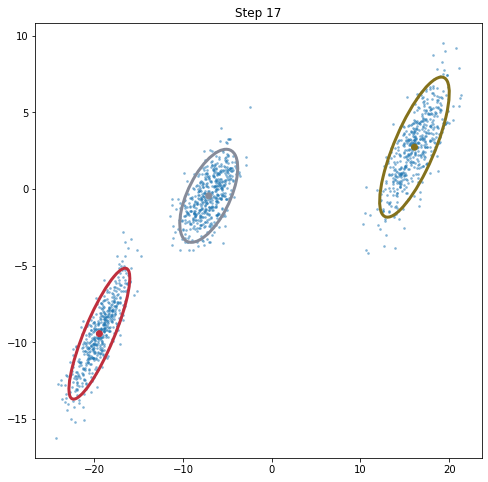

<Figure size 432x288 with 0 Axes>

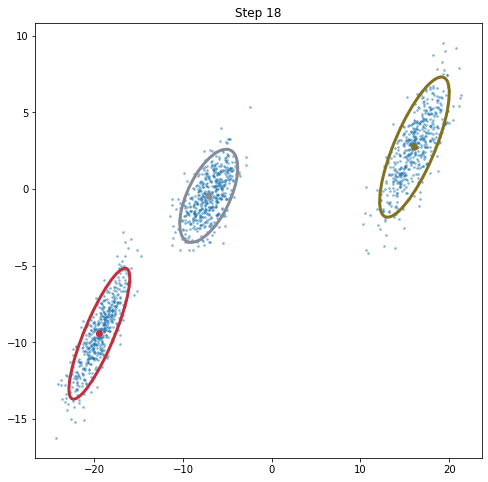

<Figure size 432x288 with 0 Axes>

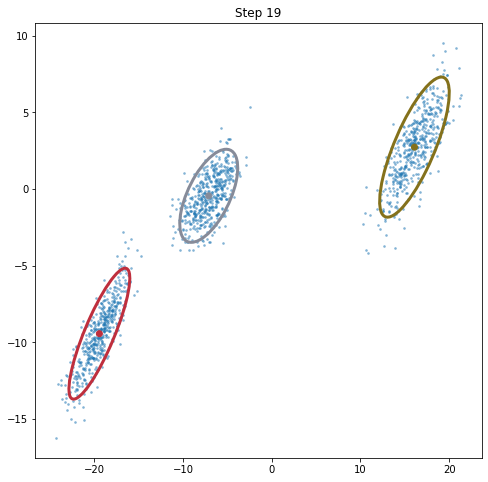

<Figure size 432x288 with 0 Axes>

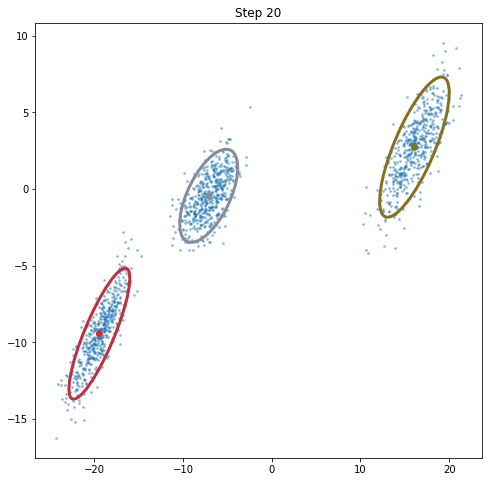

<Figure size 432x288 with 0 Axes>

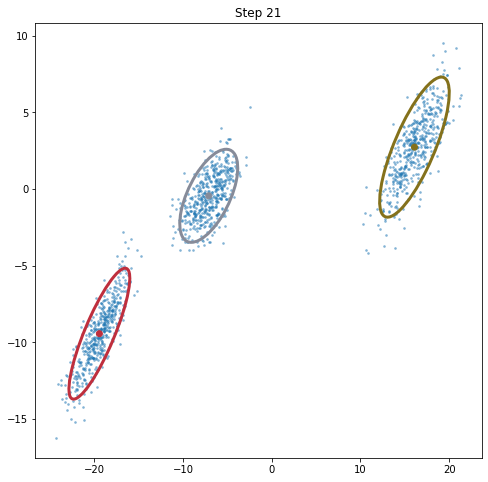

<Figure size 432x288 with 0 Axes>

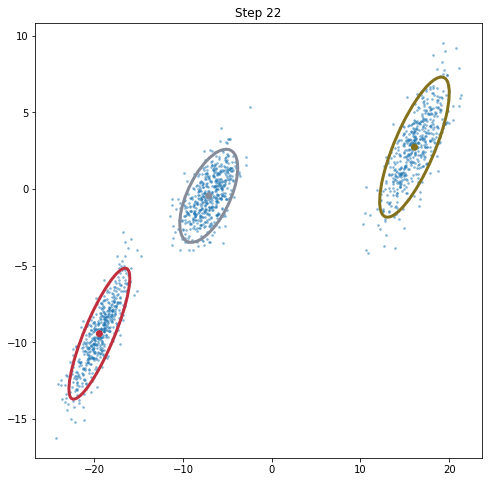

<Figure size 432x288 with 0 Axes>

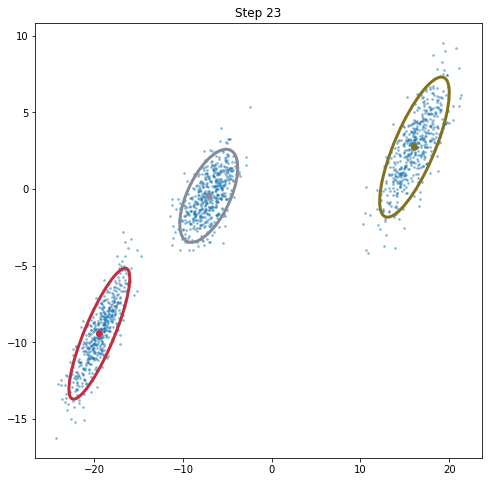

<Figure size 432x288 with 0 Axes>

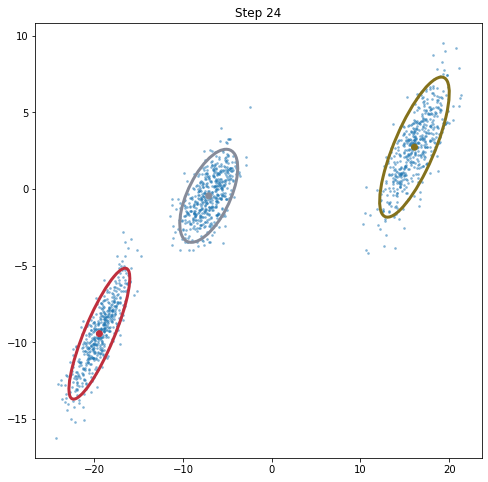

<Figure size 432x288 with 0 Axes>

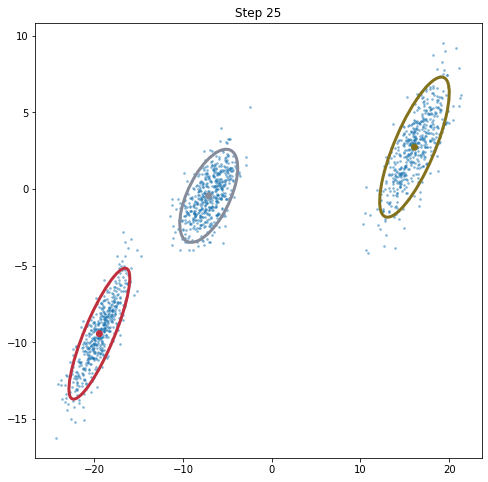

<Figure size 432x288 with 0 Axes>

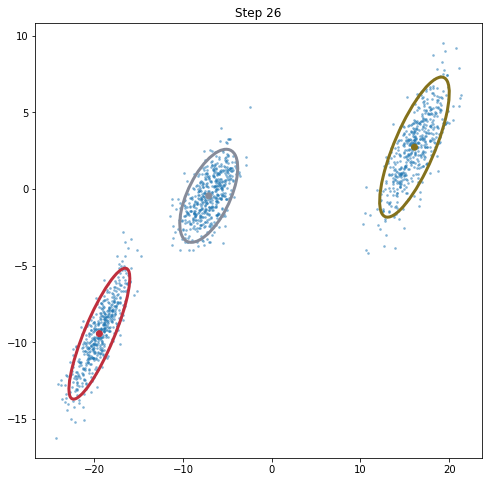

<Figure size 432x288 with 0 Axes>

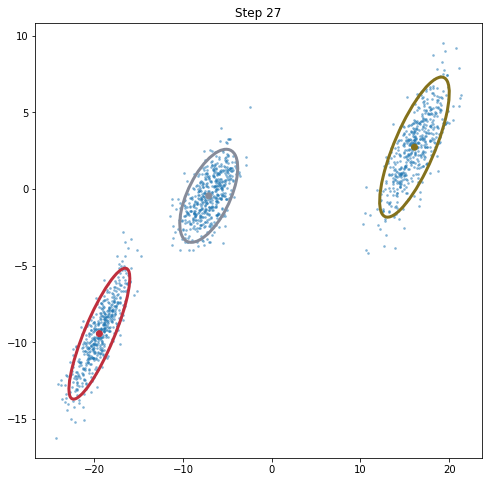

<Figure size 432x288 with 0 Axes>

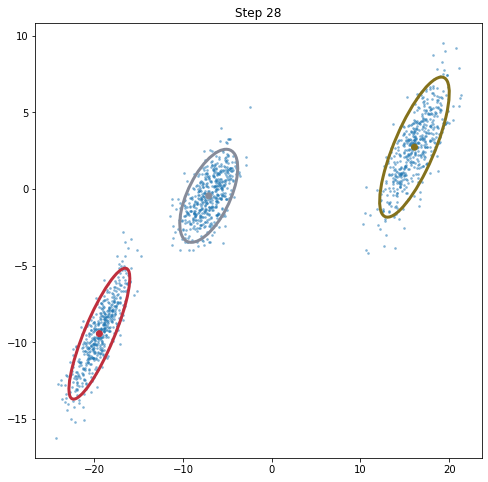

<Figure size 432x288 with 0 Axes>

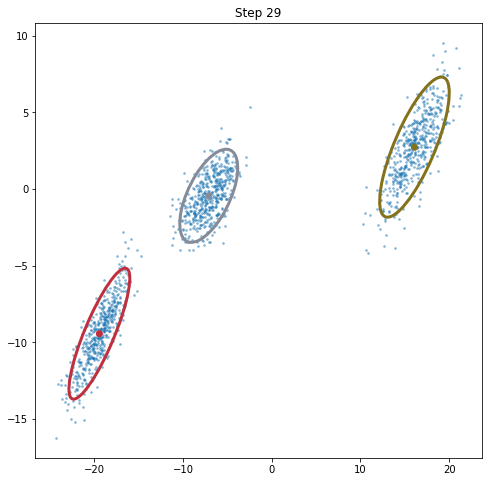

<Figure size 432x288 with 0 Axes>

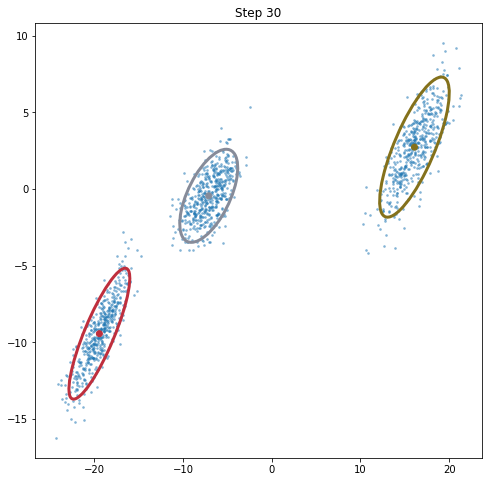

<Figure size 432x288 with 0 Axes>

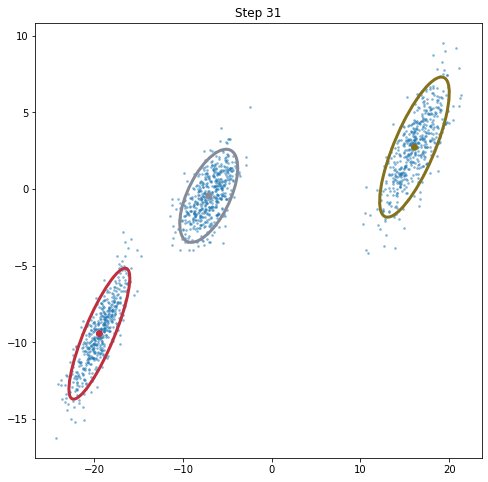

<Figure size 432x288 with 0 Axes>

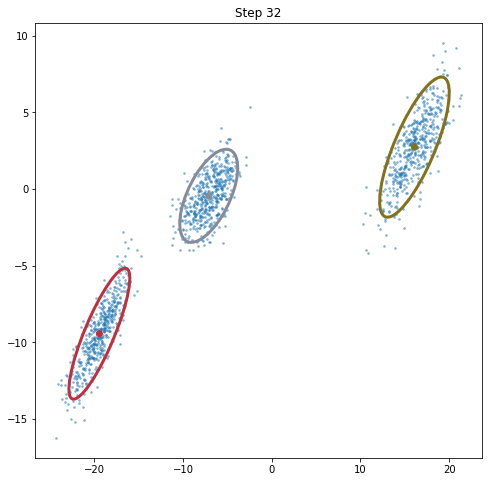

<Figure size 432x288 with 0 Axes>

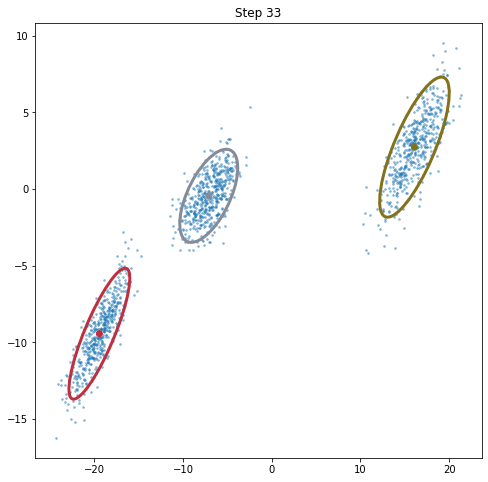

<Figure size 432x288 with 0 Axes>

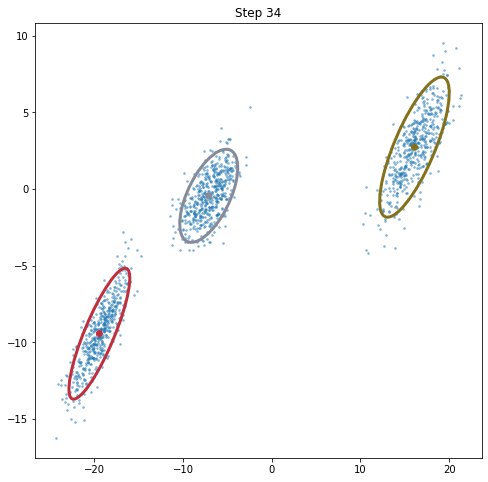

<Figure size 432x288 with 0 Axes>

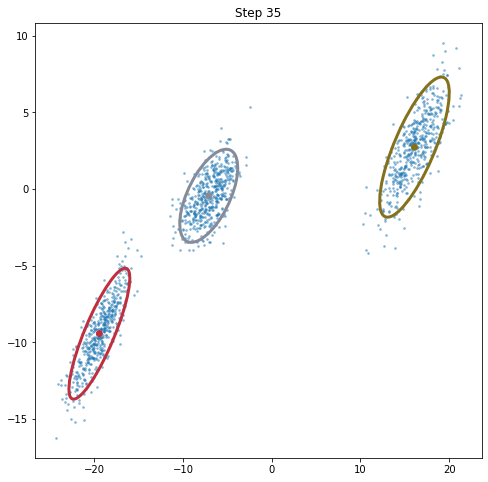

<Figure size 432x288 with 0 Axes>

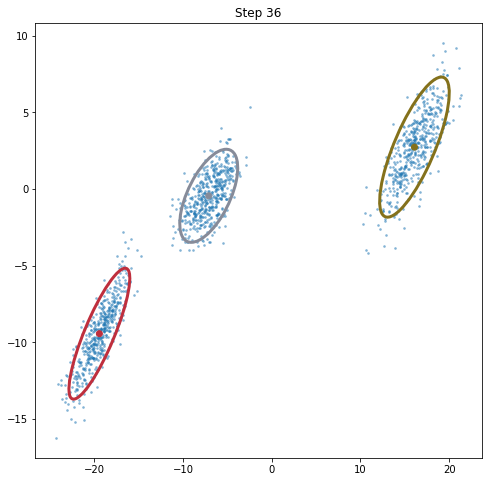

<Figure size 432x288 with 0 Axes>

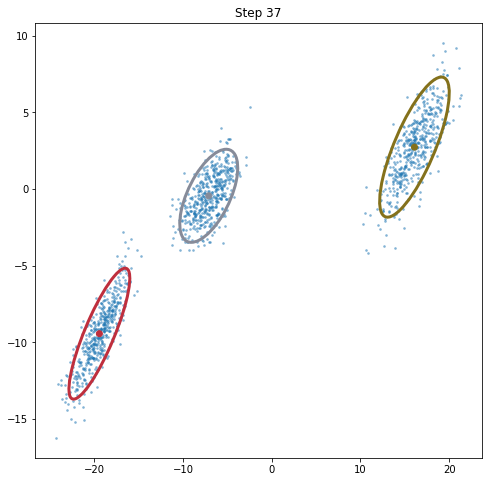

<Figure size 432x288 with 0 Axes>

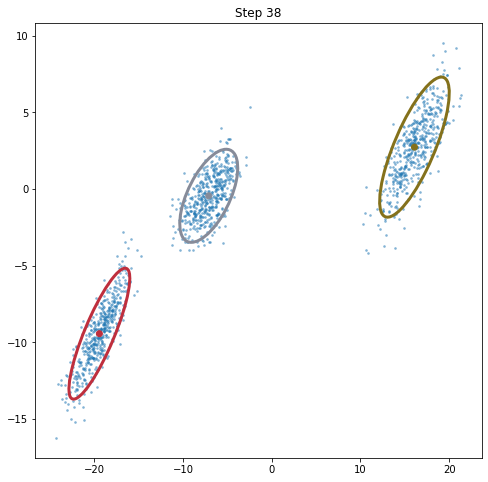

<Figure size 432x288 with 0 Axes>

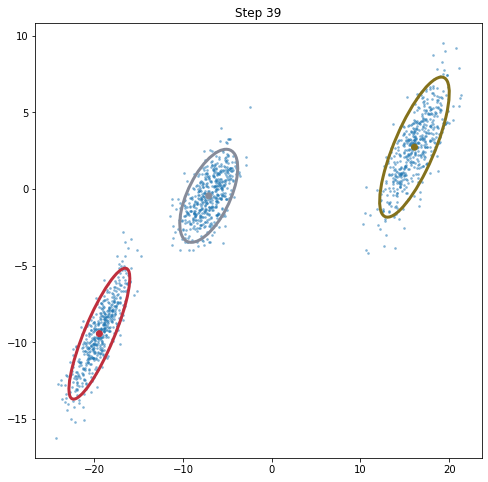

<Figure size 432x288 with 0 Axes>

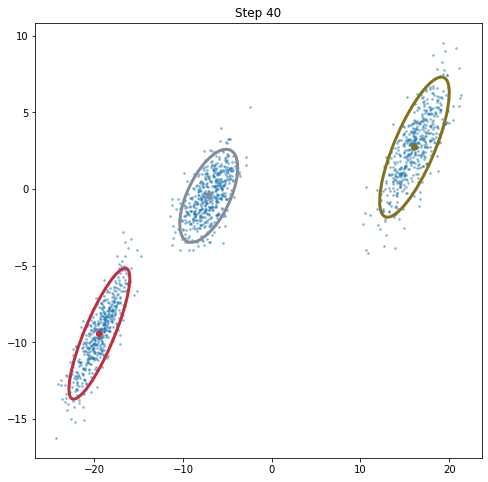

<Figure size 432x288 with 0 Axes>

In [20]:
def gen_data(num_of_gaussians=3, points_per_gaussian=200, mean_range=[-10, 10]):

  """
  Generates 2D points from a mixture of Gaussians.

  Args:
  - num_of_gaussians: Number of Gaussian components
  - points_per_gaussian: Number of points in each Gaussian component
  - mean_range: Range of mean values

  Returns:
  2D points data: Generated 2D points from a mixture of Gaussians
  num_of_points: Number of the generated points = Number of Gaussians * Number of points in each component
  """
  x = []
  mean = random.rand(num_of_gaussians, 2)*(mean_range[1]-mean_range[0]) + mean_range[0]
  for i in range(num_of_gaussians):
      cov = random.rand(2, 12)
      cov = np.matmul(cov, cov.T)
      _x = np.random.multivariate_normal(mean[i], cov, points_per_gaussian)
      x += list(_x)
  x = np.array(x)
  fig = plt.figure()
  ax = fig.gca()
  ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
  ax.autoscale(enable=True) 
  tot_points = num_of_gaussians*points_per_gaussian
  return x, tot_points

def plot(title):
    """Draw the data points and the fitted mixture model."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.means[:, 0], gmm.means[:, 1], c=gmm.colors_of_gaussians)
    gmm.draw(ax, lw=3)
    # ax.set_xlim((-12, 12))
    # ax.set_ylim((-12, 12))
    plt.title(title)
    plt.show()
    plt.clf()


NUM_OF_CLUSTERS = 3
POINTS_PER_CLUSTER = 500
MEAN_RANGE = [-20, 20]
X, NUM_OF_POINTS = gen_data(num_of_gaussians=NUM_OF_CLUSTERS, points_per_gaussian=POINTS_PER_CLUSTER, mean_range=MEAN_RANGE)

clients = []
for i in range(NUM_OF_POINTS):
  x = Client(data=X[i], num_of_gaussians=NUM_OF_CLUSTERS)
  clients.append(x)

gmm = GMM(parties=clients, num_of_parties=NUM_OF_POINTS, num_of_gaussians=NUM_OF_CLUSTERS)

NUM_OF_ITERATIONS = 40
# plotting the points alongside the Gaussian components
plot("Step 0")
for e in range(NUM_OF_ITERATIONS):
    gmm.e_step()
    gmm.m_step()
    plot(title="Step " + str(e+1))